In [94]:
# U-NET FOR A SMALLER SUBSET

In [95]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import numpy as np
import cv2
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [96]:
# Configure
IMAGE_SIZE = (256, 256)
INPUT_DIR = "./final_bf/clear_images"
MASK_DIR = "./final_masks"
THRESHOLD = 0.25
BATCH_SIZE = 4
EPOCHS = 1000

In [97]:
# Match masks to images
def extract_index(filename):
    match = re.search(r'(\d+)', filename)
    return match.group(1) if match else None

image_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(".png")])
mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.endswith(".png")])

mask_dict = {}
for mask_file in mask_files:
    idx = extract_index(mask_file)
    if idx:
        mask_dict.setdefault(idx, []).append(mask_file)

valid_image_paths = []
valid_mask_paths = []

for img_file in image_files:
    idx = extract_index(img_file)
    if idx and idx in mask_dict:
        img_path = os.path.join(INPUT_DIR, img_file)
        mask_path = os.path.join(MASK_DIR, mask_dict[idx][0])
        valid_image_paths.append(img_path)
        valid_mask_paths.append(mask_path)
    else:
        print(f"No matching mask found: {img_file}")

print(f"\n Matched {len(valid_image_paths)} image-mask pairs.")


 Matched 30 image-mask pairs.


In [98]:
#def extract_index(filename):
    #return re.search(r'(\d+)', filename).group(1)  # extract index from filename

# Build a map from index → mask
#mask_dict = {}
#for f in os.listdir(MASK_DIR):
   # if f.endswith(".png"):
   #     idx = extract_index(f)
   #     mask_dict[idx] = os.path.join(MASK_DIR, f)
#
# Match image with correct mask
#valid_image_paths = []
#valid_mask_paths = []

#for f in os.listdir(INPUT_DIR):
    #if f.endswith(".png"):
        #idx = extract_index(f)
       # if idx in mask_dict:
        #    valid_image_paths.append(os.path.join(INPUT_DIR, f))
         #   valid_mask_paths.append(mask_dict[idx])


In [99]:
# Loading images and matching the final_masks
image_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(".png")])
image_paths = [os.path.join(INPUT_DIR, f) for f in image_files]
mask_paths = [os.path.join(MASK_DIR, f) for f in image_files] 

In [100]:
# Load and preprocess
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMAGE_SIZE)
    img = np.stack([img]*3, axis=-1)
    return img.astype(np.float32) / 255.0

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    return (mask.astype(np.float32) / 255.0)[..., np.newaxis]

X = np.array([load_image(p) for p in tqdm(valid_image_paths, desc="Loading images")])
y = np.array([load_mask(p) for p in tqdm(valid_mask_paths, desc="Loading masks")])












Loading images: 100%|██████████| 30/30 [00:01<00:00, 19.73it/s]






Loading masks: 100%|██████████| 30/30 [00:00<00:00, 52.46it/s]


In [101]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Define U-Net model
def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    concat2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat2)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D()(c4)
    concat1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat1)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    model = models.Model(inputs, outputs)
    return model

In [103]:
# Dice Loss 
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# BCE + Dice Hybrid Loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Re-compile your model with Dice loss
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

print("U-Net recompiled with Dice loss.")

U-Net recompiled with Dice loss.


In [104]:
# Complile the model
model = build_unet((256, 256, 3))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])

In [105]:
# Train the model with a timer
print("Starting training...")
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
end_time = time.time()
print(f"\n Training completed in {(end_time - start_time):.2f} seconds.")

Starting training...
Epoch 1/1000


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.8284 - loss: 1.3420 - val_accuracy: 0.8283 - val_loss: 1.2868
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8219 - loss: 1.2800 - val_accuracy: 0.8283 - val_loss: 1.2771
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8305 - loss: 1.2672 - val_accuracy: 0.8283 - val_loss: 1.2710
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8161 - loss: 1.2664 - val_accuracy: 0.8283 - val_loss: 1.3815
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8323 - loss: 1.2891 - val_accuracy: 0.8283 - val_loss: 1.2600
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8289 - loss: 1.2593 - val_accuracy: 0.8283 - val_loss: 1.2512
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8313 - loss: 1.2477 - val_accuracy: 0.8283 - val_loss: 1.2426
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8270 - loss: 1.2355 - val_accuracy: 0.8283 - val_lo

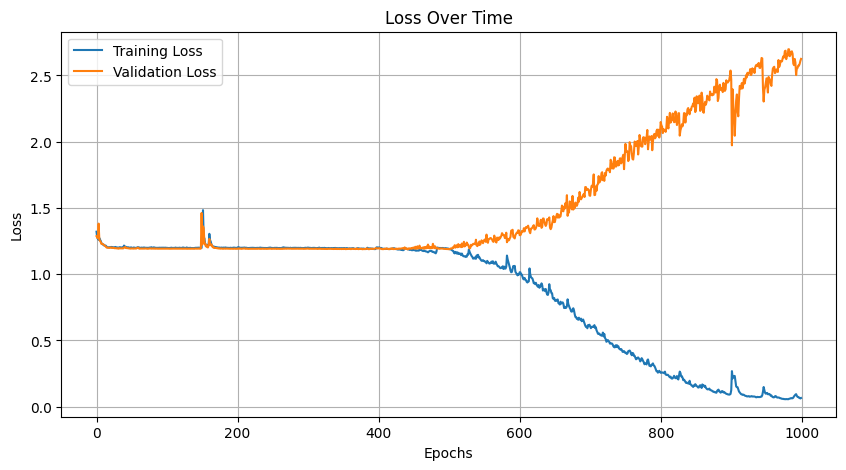

In [106]:
# Plotting loss curve

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [107]:
predictions = model.predict(X, batch_size=1)
predictions_binary = (predictions > 0.25).astype(np.uint8)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [108]:
# Predict on all images
print("Predicting on all images...")
predictions = model.predict(X, batch_size=1, verbose=1)
predictions_binary = (predictions > THRESHOLD).astype(np.uint8)

Predicting on all images...
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [109]:
from sklearn.metrics import f1_score, jaccard_score

best_threshold = 0
best_dice = 0
thresholds = np.arange(0.05, 0.5, 0.05)

y_true_flat = (y > 0.5).astype(np.uint8).flatten()

for t in thresholds:
    pred_bin = (predictions > t).astype(np.uint8).flatten()
    dice = f1_score(y_true_flat, pred_bin)
    print(f"Threshold {t:.2f} → Dice: {dice:.4f}")
    
    if dice > best_dice:
        best_dice = dice
        best_threshold = t

print(f"\n Best threshold: {best_threshold:.2f} with Dice score: {best_dice:.4f}")


Threshold 0.05 → Dice: 0.8273
Threshold 0.10 → Dice: 0.8355


Threshold 0.15 → Dice: 0.8392
Threshold 0.20 → Dice: 0.8413
Threshold 0.25 → Dice: 0.8427
Threshold 0.30 → Dice: 0.8437
Threshold 0.35 → Dice: 0.8443
Threshold 0.40 → Dice: 0.8448
Threshold 0.45 → Dice: 0.8450

 Best threshold: 0.45 with Dice score: 0.8450


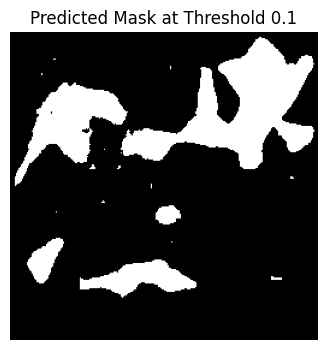

Loading masks:   0%|          | 0/30 [5:08:27<?, ?it/s]


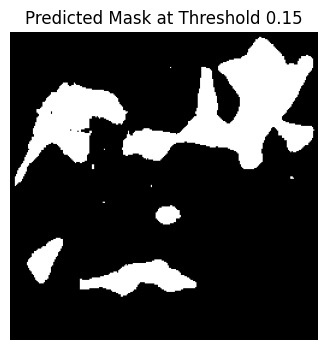

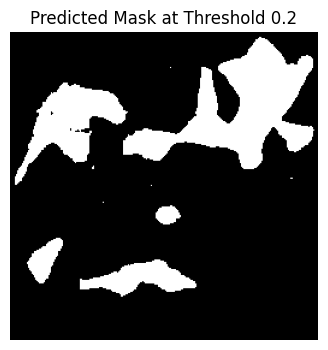

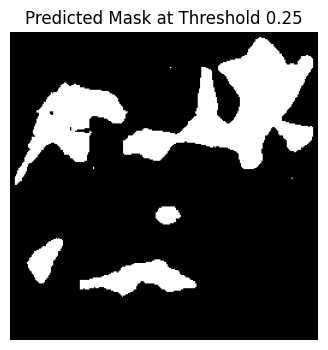

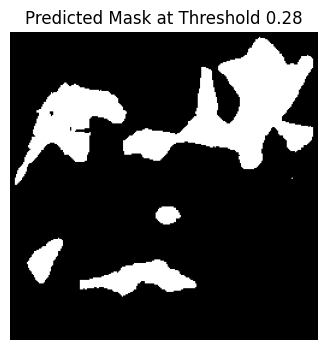

In [110]:
# Explore different thresholds 
thresholds = [0.1, 0.15, 0.2, 0.25, 0.28]

for t in thresholds:
    bin_mask = (predictions[0] > t).astype(np.uint8)
    plt.figure(figsize=(4, 4))
    plt.imshow(bin_mask.squeeze(), cmap='gray')
    plt.title(f'Predicted Mask at Threshold {t}')
    plt.axis('off')
    plt.show()

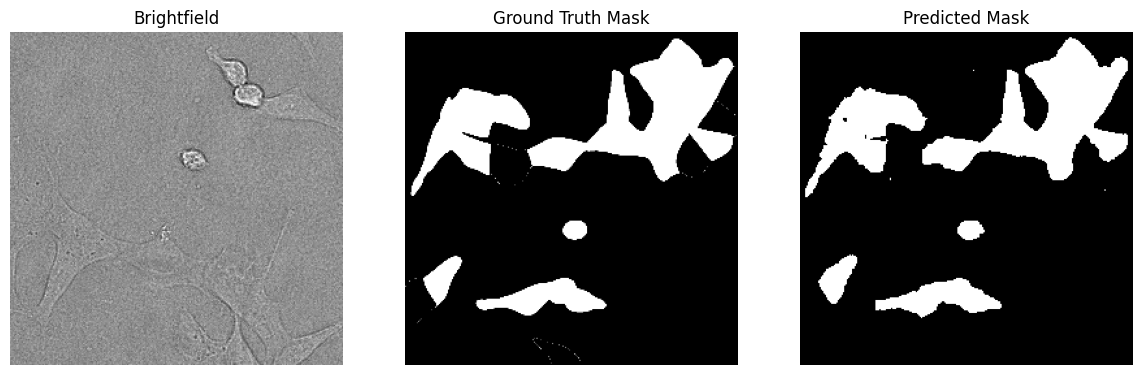

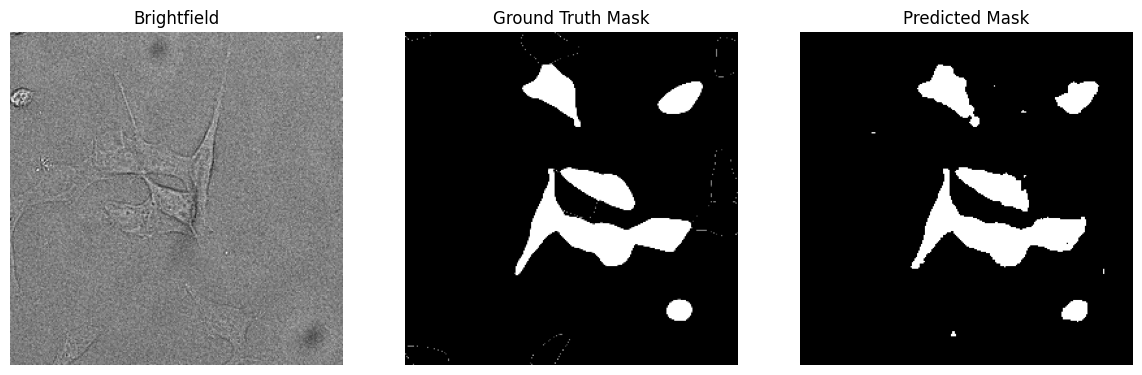

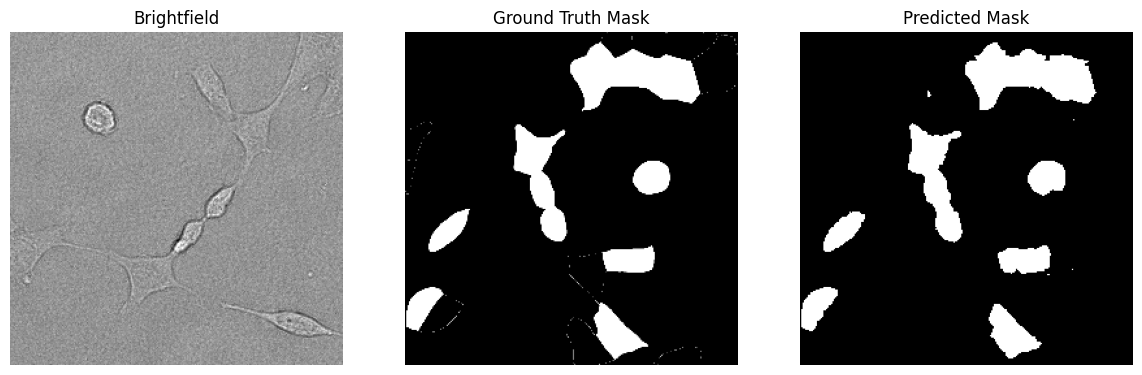

376_rotated119_.png


In [111]:
# Examples
for i in range(3):  
    img_name = os.path.basename(valid_image_paths[i])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.mean(X[i], axis=-1), cmap='gray')
    plt.title("Brightfield")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predictions_binary[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
print(img_name)


In [112]:
print("Max prediction value:", np.max(predictions))
print("Min prediction value:", np.min(predictions))


Max prediction value: 1.0
Min prediction value: 0.0
